# AIRL Evalutation on Classification Task and Quality of Learned Policy

In [1]:
import ast

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.ppo import MlpPolicy

import graph_reinforcement_learning_using_blockchain_data as grl

2025-06-11 16:30:26.669 | INFO     | graph_reinforcement_learning_using_blockchain_data.config:<module>:11 - PROJ_ROOT path is: /Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data


## Setup

In [2]:
file_paths = [
    grl.PROCESSED_DATA_DIR / "AIRL" / "airl_1_train.csv",
    grl.PROCESSED_DATA_DIR / f"AIRL" / "airl_1_test.csv",
    grl.PROCESSED_DATA_DIR / "AIRL" / "airl_val.csv",
    grl.PROCESSED_DATA_DIR / "AIRL" / "airl_0_train.csv",
    grl.PROCESSED_DATA_DIR / "AIRL" / "airl_0_test.csv",
    grl.PROCESSED_DATA_DIR / "AIRL" / "state_embeddings.csv",
    grl.PROCESSED_DATA_DIR / "AIRL" / "state_embeddings_dgi_128.csv",
    grl.PROCESSED_DATA_DIR / "AIRL" / "state_embeddings_pre_trained_128.csv",
]

In [3]:
eth_data_dict = grl.load_dataframes(file_paths[:5])
embeddings_dict = grl.load_dataframes(file_paths[5:])

/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/graph_reinforcement_learning_using_blockchain_data/utils.py:121: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes_dict[key] = pd.read_csv(path)


In [4]:
for k, df in embeddings_dict.items():
    df["embeddings"] = df["embeddings"].apply(
        lambda x: np.array(ast.literal_eval(x), dtype=np.float32)
    )
    embeddings_dict[k] = df

In [5]:
data_dict = {}
for k, emb in embeddings_dict.items():
    data_dict.setdefault(k, {})
    for key, df in eth_data_dict.items():
        data_dict[k][key] = pd.merge(
            df, emb, how="inner", left_on="transaction_hash", right_on="transactionHash"
        )

In [6]:
trajectories = {}
for k, dicti in data_dict.items():
    trajectories[k] = grl.extract_trajectories(dicti)

In [7]:
gnn_dict = {
    "state_embeddings": "mlflow-artifacts:/748752183556303764/d5126473f0714e61851be1b09c0d1d40/artifacts/model",
    "state_embeddings_pre_trained_128": "mlflow-artifacts:/132032870842317128/7559d28e50674e629ce8042ea64902de/artifacts/model",
    "state_embeddings_dgi_128": "mlflow-artifacts:/330930495026013213/7cd9300ef7834a76980e2ec75347bbae/artifacts/model",
}

In [8]:
venvs = {}
for k, df_dict in data_dict.items():
    grl.register_envs(df_dict, gnn_dict[k], 1, k)
    venvs[k] = grl.make_venvs(df_dict, k)

In [9]:
def download_reward_net(url: str) -> torch.nn.Module:
    url = mlflow.artifacts.download_artifacts(artifact_uri=url)
    reward_net = torch.load(url, weights_only=False)
    reward_net.eval()
    return reward_net


def download_learner(url: str):
    url = mlflow.artifacts.download_artifacts(artifact_uri=url)
    learner_trained = PPO.load(url, weights_only=False)
    return learner_trained

In [10]:
def calculate_calibrated_rewards(
    reward_net0, reward_net1, alpha0, alpha1, beta0, beta1, test_trajectories
):
    states, obs, next_states, dones = (
        test_trajectories.obs,
        test_trajectories.acts,
        test_trajectories.next_obs,
        test_trajectories.dones,
    )
    with torch.no_grad():
        # For reward_net0
        rewards0 = reward_net0.predict(states, obs, next_states, dones)
        calibrated_rewards0 = alpha0 * rewards0 + beta0
        print("Reward network 0: ", calibrated_rewards0.mean())

        # For reward_net1
        rewards1 = reward_net1.predict(states, obs, next_states, dones)
        calibrated_rewards1 = alpha1 * rewards1 + beta1
        print("Reward network 1: ", calibrated_rewards1.mean())

    return calibrated_rewards0, calibrated_rewards1

In [11]:
def calc_stats(y_pred, y):
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

In [12]:
def calc_overall_metrics(rewards0_traj_0, rewards1_traj_0, rewards1_traj0, rewards1_traj1):
    predictions_trajectories_0 = [
        0 if r0 > r1 else 1 for r0, r1 in zip(rewards0_traj_0, rewards1_traj_0)
    ]
    true_labels_0 = [0] * len(predictions_trajectories_0)

    predictions_trajectories_1 = [
        1 if r0 < r1 else 0 for r0, r1 in zip(rewards1_traj0, rewards1_traj1)
    ]

    true_labels_1 = [1] * len(predictions_trajectories_1)

    print(len(true_labels_0), len(true_labels_1))

    predictions = predictions_trajectories_0 + predictions_trajectories_1

    true_labels = true_labels_0 + true_labels_1

    calc_stats(predictions, true_labels)
    return true_labels, predictions

In [13]:
def eval_policy(learner, n_episodes, venv, case):
    venv.seed(42)

    rewards, episode_len = evaluate_policy(learner, venv, n_episodes, return_episode_rewards=True)

    rewards = [r / l for r, l in zip(rewards, episode_len)]

    print("Mean episode length: ", np.mean(episode_len))
    print(f"Reward of the learner policy {case} training")
    print("Mean: ", np.mean(rewards))
    print("Std: ", np.std(rewards))

In [14]:
kwargs_class1 = {
    # PPO hyper-params
    "learning_rate": 2e-4,  # Learning rate can be a function of progress
    "batch_size": 256,  # Mini batch size for each gradient update
    "n_epochs": 10,  # N of epochs when optimizing the surrogate loss
    "gamma": 0.99,  # Discount factor
    "gae_lambda": 0.95,  # Generalized advantage estimation
    "clip_range": 0.25,  # Clipping parameter
    "ent_coef": 0.05,  # Entropy coefficient for the loss calculation
    "vf_coef": 1.0,  # Value function coef. for the loss calculation
    "max_grad_norm": 0.5,  # The maximum value for the gradient clipping
    "verbose": 0,  # Verbosity level: 0 no output, 1 info, 2 debug
    "normalize_advantage": False,  # Whether to normalize or not the advantage
    "use_sde": False,  # Use State Dependent Exploration
    "sde_sample_freq": -1,  # SDE - noise matrix frequency (-1 = disable)
    "policy_kwargs": {"use_expln": True},
    # PPO roll-out length
    "gen_train_timesteps": 2048,  # N steps in the environment per one round
    "n_steps": 2048,
    # AIRL discriminator
    "n_disc_updates_per_round": 8,  # N discriminator updates per one round
    "disc_opt_kwargs": {
        "lr": 1e-3,
        "weight_decay": 1e-4,
    },
    "demo_minibatch_size": 128,  # N samples in minibatch for one discrim. update
    "demo_batch_size": 640,  # N samples in the batch of expert data (batch)
    "allow_variable_horizon": True,
    "gen_replay_buffer_capacity": None,
    # total training
    "total_timesteps": 2048 * 100,
}

kwargs_class0 = {
    # PPO hyper-params
    "learning_rate": 5e-4,  # Learning rate can be a function of progress
    "batch_size": 256,  # Mini batch size for each gradient update
    "n_epochs": 10,  # N of epochs when optimizing the surrogate loss
    "gamma": 0.9,  # Discount factor
    "gae_lambda": 0.8,  # Generalized advantage estimation
    "clip_range": 0.25,  # Clipping parameter
    "ent_coef": 0.03,  # Entropy coefficient for the loss calculation
    "vf_coef": 0.5,  # Value function coef. for the loss calculation
    "max_grad_norm": 0.5,  # The maximum value for the gradient clipping
    "verbose": 0,  # Verbosity level: 0 no output, 1 info, 2 debug
    "normalize_advantage": True,  # Whether to normalize or not the advantage
    "use_sde": False,  # Use State Dependent Exploration
    "sde_sample_freq": -1,  # SDE - noise matrix frequency (-1 = disable)
    "policy_kwargs": {"use_expln": True},
    # PPO roll-out length
    "gen_train_timesteps": 2048,  # N steps in the environment per one round
    "n_steps": 1024,
    # AIRL discriminator
    "n_disc_updates_per_round": 6,  # N discriminator updates per one round
    "disc_opt_kwargs": {
        "lr": 1e-3,
        "weight_decay": 1e-4,
    },
    "demo_minibatch_size": 128,  # N samples in minibatch for one discrim. update
    "demo_batch_size": 512,  # N samples in the batch of expert data (batch)
    "allow_variable_horizon": True,
    "gen_replay_buffer_capacity": None,
    # total training
    "total_timesteps": 2048 * 200,
}

In [15]:
def plot_cm(true_labels, predictions):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()

## Supervised AIRL Evaluation

### Classification

In [16]:
airl_supervised_rn_0 = download_reward_net(
    "mlflow-artifacts:/282678262450638424/ae0d8217fe5342a987e7a936182ee252/artifacts/reward_net"
)
airl_supervised_rn_1 = download_reward_net(
    "mlflow-artifacts:/282678262450638424/8d998b384c584c9bb1a04e2c9ec3c8e8/artifacts/reward_net"
)

In [17]:
alpha_sup_0, beta_sup_0 = grl.calibrate(
    trajectories["state_embeddings"]["airl_val"], airl_supervised_rn_0
)
alpha_sup_1, beta_sup_1 = grl.calibrate(
    trajectories["state_embeddings"]["airl_val"], airl_supervised_rn_1
)

In [18]:
rewards_cal_sup0_traj_0, rewards_cal_sup1_traj_0 = calculate_calibrated_rewards(
    airl_supervised_rn_0,
    airl_supervised_rn_1,
    alpha_sup_0,
    alpha_sup_1,
    beta_sup_0,
    beta_sup_1,
    trajectories["state_embeddings"]["airl_0_test"],
)
rewards_cal_sup0_traj_1, rewards_cal_sup1_traj_1 = calculate_calibrated_rewards(
    airl_supervised_rn_0,
    airl_supervised_rn_1,
    alpha_sup_0,
    alpha_sup_1,
    beta_sup_0,
    beta_sup_1,
    trajectories["state_embeddings"]["airl_1_test"],
)

Reward network 0:  0.82962793
Reward network 1:  -0.72045654
Reward network 0:  -1.0999024
Reward network 1:  0.8209237


In [19]:
true_labels, predictions = calc_overall_metrics(
    rewards_cal_sup0_traj_0,
    rewards_cal_sup1_traj_0,
    rewards_cal_sup0_traj_1,
    rewards_cal_sup1_traj_1,
)

4199 15595
Accuracy: 0.9911589370516318
Precision: 0.9958199356913183
Recall: 0.9929464571978198
F1 Score: 0.9943811205650988


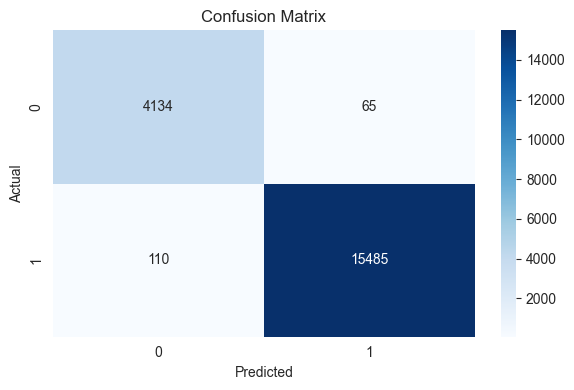

In [20]:
plot_cm(true_labels, predictions)

### Learner

In [21]:
learner0 = download_learner(
    "mlflow-artifacts:/282678262450638424/ae0d8217fe5342a987e7a936182ee252/artifacts/learner.zip"
)
learner1 = download_learner(
    "mlflow-artifacts:/282678262450638424/8d998b384c584c9bb1a04e2c9ec3c8e8/artifacts/learner.zip"
)

In [22]:
learner0_untrained = PPO(
    env=venvs["state_embeddings"]["airl_0_test"],
    policy=MlpPolicy,
    policy_kwargs=kwargs_class0.get("policy_kwargs"),
    learning_rate=kwargs_class0.get("learning_rate"),
    n_steps=kwargs_class0.get("n_steps"),
    batch_size=kwargs_class0.get("batch_size"),
    n_epochs=kwargs_class0.get("n_epochs"),
    gamma=kwargs_class0.get("gamma"),
    gae_lambda=kwargs_class0.get("gae_lambda"),
    clip_range=kwargs_class0.get("clip_range"),
    clip_range_vf=kwargs_class0.get("clip_range_vf"),
    normalize_advantage=kwargs_class0.get("normalize_advantage"),
    ent_coef=kwargs_class0.get("ent_coef"),
    vf_coef=kwargs_class0.get("vf_coef"),
    max_grad_norm=kwargs_class0.get("max_grad_norm"),
    use_sde=kwargs_class0.get("use_sde"),
    sde_sample_freq=kwargs_class0.get("sde_sample_freq"),
    verbose=kwargs_class0.get("verbose"),
    seed=42,
    device="mps",
)

learner1_untrained = PPO(
    env=venvs["state_embeddings"]["airl_1_test"],
    policy=MlpPolicy,
    policy_kwargs=kwargs_class1.get("policy_kwargs"),
    learning_rate=kwargs_class1.get("learning_rate"),
    n_steps=kwargs_class1.get("n_steps"),
    batch_size=kwargs_class1.get("batch_size"),
    n_epochs=kwargs_class1.get("n_epochs"),
    gamma=kwargs_class1.get("gamma"),
    gae_lambda=kwargs_class1.get("gae_lambda"),
    clip_range=kwargs_class1.get("clip_range"),
    clip_range_vf=kwargs_class1.get("clip_range_vf"),
    normalize_advantage=kwargs_class1.get("normalize_advantage"),
    ent_coef=kwargs_class1.get("ent_coef"),
    vf_coef=kwargs_class1.get("vf_coef"),
    max_grad_norm=kwargs_class1.get("max_grad_norm"),
    use_sde=kwargs_class1.get("use_sde"),
    sde_sample_freq=kwargs_class1.get("sde_sample_freq"),
    verbose=kwargs_class1.get("verbose"),
    seed=42,
    device="mps",
)

In [23]:
eval_policy(learner0_untrained, 100, venvs["state_embeddings"]["airl_0_test"], "before")
eval_policy(learner0, 100, venvs["state_embeddings"]["airl_0_test"], "after")

Mean episode length:  5.09
Reward of the learner policy before training
Mean:  0.45097009265244553
Std:  0.3790013939359703
Mean episode length:  5.09
Reward of the learner policy after training
Mean:  0.5353314501185089
Std:  0.3777621706627631


In [24]:
eval_policy(learner1_untrained, 100, venvs["state_embeddings"]["airl_1_test"], "before")
eval_policy(learner1, 100, venvs["state_embeddings"]["airl_1_test"], "after")

Mean episode length:  18.81
Reward of the learner policy before training
Mean:  0.49303917014820847
Std:  0.41584053868822113
Mean episode length:  18.81
Reward of the learner policy after training
Mean:  0.8430170104856777
Std:  0.2631333759555989


## Semi-Supervised AIRL Evaluation

### Classification

In [25]:
rn0 = download_reward_net(
    "mlflow-artifacts:/720343879195193287/aaeddf690ee347759b8da5ebe7dcf153/artifacts/reward_net"
)
rn1 = download_reward_net(
    "mlflow-artifacts:/720343879195193287/289e810d3ec24672897417e082aed201/artifacts/reward_net"
)

In [26]:
alpha0, beta0 = grl.calibrate(trajectories["state_embeddings_pre_trained_128"]["airl_val"], rn0)
alpha1, beta1 = grl.calibrate(trajectories["state_embeddings_pre_trained_128"]["airl_val"], rn1)

In [27]:
rewards_cal0_traj_0, rewards_cal1_traj_0 = calculate_calibrated_rewards(
    rn0,
    rn1,
    alpha0,
    alpha1,
    beta0,
    beta1,
    trajectories["state_embeddings_pre_trained_128"]["airl_0_test"],
)
rewards_cal0_traj_1, rewards_cal1_traj_1 = calculate_calibrated_rewards(
    rn0,
    rn1,
    alpha0,
    alpha1,
    beta0,
    beta1,
    trajectories["state_embeddings_pre_trained_128"]["airl_1_test"],
)

Reward network 0:  0.79372144
Reward network 1:  -0.2678718
Reward network 0:  -0.8684994
Reward network 1:  0.3751088


In [28]:
true_labels, predictions = calc_overall_metrics(
    rewards_cal0_traj_0, rewards_cal1_traj_0, rewards_cal0_traj_1, rewards_cal1_traj_1
)

4199 15595
Accuracy: 0.9644841871274124
Precision: 0.9664244550238036
Recall: 0.9892914395639628
F1 Score: 0.9777242624924745


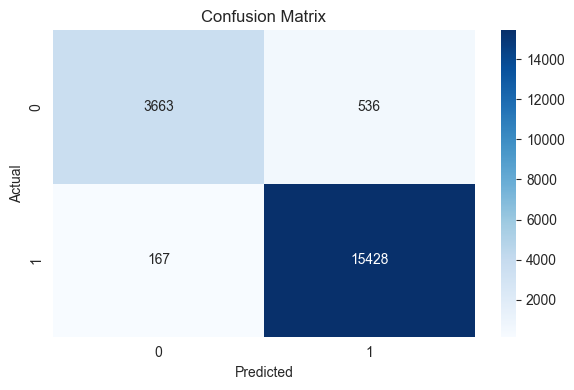

In [29]:
plot_cm(true_labels, predictions)

## Learner

In [30]:
learner0 = download_learner(
    "mlflow-artifacts:/720343879195193287/aaeddf690ee347759b8da5ebe7dcf153/artifacts/learner.zip"
)
learner1 = download_learner(
    "mlflow-artifacts:/720343879195193287/289e810d3ec24672897417e082aed201/artifacts/learner.zip"
)

In [31]:
learner0_untrained = PPO(
    env=venvs["state_embeddings_pre_trained_128"]["airl_0_test"],
    policy=MlpPolicy,
    policy_kwargs=kwargs_class0.get("policy_kwargs"),
    learning_rate=kwargs_class0.get("learning_rate"),
    n_steps=kwargs_class0.get("n_steps"),
    batch_size=kwargs_class0.get("batch_size"),
    n_epochs=kwargs_class0.get("n_epochs"),
    gamma=kwargs_class0.get("gamma"),
    gae_lambda=kwargs_class0.get("gae_lambda"),
    clip_range=kwargs_class0.get("clip_range"),
    clip_range_vf=kwargs_class0.get("clip_range_vf"),
    normalize_advantage=kwargs_class0.get("normalize_advantage"),
    ent_coef=kwargs_class0.get("ent_coef"),
    vf_coef=kwargs_class0.get("vf_coef"),
    max_grad_norm=kwargs_class0.get("max_grad_norm"),
    use_sde=kwargs_class0.get("use_sde"),
    sde_sample_freq=kwargs_class0.get("sde_sample_freq"),
    verbose=kwargs_class0.get("verbose"),
    seed=42,
    device="mps",
)

learner1_untrained = PPO(
    env=venvs["state_embeddings_pre_trained_128"]["airl_1_test"],
    policy=MlpPolicy,
    policy_kwargs=kwargs_class1.get("policy_kwargs"),
    learning_rate=kwargs_class1.get("learning_rate"),
    n_steps=kwargs_class1.get("n_steps"),
    batch_size=kwargs_class1.get("batch_size"),
    n_epochs=kwargs_class1.get("n_epochs"),
    gamma=kwargs_class1.get("gamma"),
    gae_lambda=kwargs_class1.get("gae_lambda"),
    clip_range=kwargs_class1.get("clip_range"),
    clip_range_vf=kwargs_class1.get("clip_range_vf"),
    normalize_advantage=kwargs_class1.get("normalize_advantage"),
    ent_coef=kwargs_class1.get("ent_coef"),
    vf_coef=kwargs_class1.get("vf_coef"),
    max_grad_norm=kwargs_class1.get("max_grad_norm"),
    use_sde=kwargs_class1.get("use_sde"),
    sde_sample_freq=kwargs_class1.get("sde_sample_freq"),
    verbose=kwargs_class1.get("verbose"),
    seed=42,
    device="mps",
)

In [32]:
eval_policy(
    learner0_untrained, 1000, venvs["state_embeddings_pre_trained_128"]["airl_0_test"], "before"
)
eval_policy(learner0, 100, venvs["state_embeddings_pre_trained_128"]["airl_0_test"], "after")

Mean episode length:  5.298
Reward of the learner policy before training
Mean:  0.4337138339166122
Std:  0.39638100234934276
Mean episode length:  5.09
Reward of the learner policy after training
Mean:  0.576275987933635
Std:  0.37608510727539246


In [33]:
eval_policy(
    learner1_untrained, 100, venvs["state_embeddings_pre_trained_128"]["airl_1_test"], "before"
)
eval_policy(learner1, 100, venvs["state_embeddings_pre_trained_128"]["airl_1_test"], "after")

Mean episode length:  18.81
Reward of the learner policy before training
Mean:  0.644039205746382
Std:  0.3876511130571336
Mean episode length:  18.81
Reward of the learner policy after training
Mean:  0.8346836771523445
Std:  0.26793554644706097


## Unsupervised AIRL Evaluation

### Classification

In [34]:
rn0 = download_reward_net(
    "mlflow-artifacts:/727687587886726594/e7c8ffd2d6014e5ba4a8fb3d2887fe45/artifacts/reward_net"
)
rn1 = download_reward_net(
    "mlflow-artifacts:/727687587886726594/d29dacdb20d94e10a25953d2171959a7/artifacts/reward_net"
)

In [35]:
alpha0, beta0 = grl.calibrate(trajectories["state_embeddings_dgi_128"]["airl_val"], rn0)
alpha1, beta1 = grl.calibrate(trajectories["state_embeddings_dgi_128"]["airl_val"], rn1)

In [36]:
rewards_cal0_traj_0, rewards_cal1_traj_0 = calculate_calibrated_rewards(
    rn0,
    rn1,
    alpha0,
    alpha1,
    beta0,
    beta1,
    trajectories["state_embeddings_dgi_128"]["airl_0_test"],
)
rewards_cal0_traj_1, rewards_cal1_traj_1 = calculate_calibrated_rewards(
    rn0,
    rn1,
    alpha0,
    alpha1,
    beta0,
    beta1,
    trajectories["state_embeddings_dgi_128"]["airl_1_test"],
)

Reward network 0:  0.1712937
Reward network 1:  -0.40936977
Reward network 0:  -0.086550206
Reward network 1:  0.5354227


In [37]:
true_labels, predictions = calc_overall_metrics(
    rewards_cal0_traj_0, rewards_cal1_traj_0, rewards_cal0_traj_1, rewards_cal1_traj_1
)

4199 15595
Accuracy: 0.8521774275032838
Precision: 0.9298948082796064
Recall: 0.8786149406861173
F1 Score: 0.9035278602044181


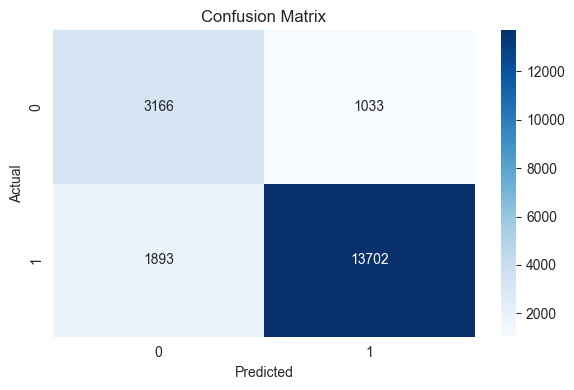

In [38]:
plot_cm(true_labels, predictions)

### Learner

In [39]:
learner0 = download_learner(
    "mlflow-artifacts:/727687587886726594/e7c8ffd2d6014e5ba4a8fb3d2887fe45/artifacts/learner.zip"
)
learner1 = download_learner(
    "mlflow-artifacts:/727687587886726594/d29dacdb20d94e10a25953d2171959a7/artifacts/learner.zip"
)

In [40]:
learner0_untrained = PPO(
    env=venvs["state_embeddings_dgi_128"]["airl_0_test"],
    policy=MlpPolicy,
    policy_kwargs=kwargs_class0.get("policy_kwargs"),
    learning_rate=kwargs_class0.get("learning_rate"),
    n_steps=kwargs_class0.get("n_steps"),
    batch_size=kwargs_class0.get("batch_size"),
    n_epochs=kwargs_class0.get("n_epochs"),
    gamma=kwargs_class0.get("gamma"),
    gae_lambda=kwargs_class0.get("gae_lambda"),
    clip_range=kwargs_class0.get("clip_range"),
    clip_range_vf=kwargs_class0.get("clip_range_vf"),
    normalize_advantage=kwargs_class0.get("normalize_advantage"),
    ent_coef=kwargs_class0.get("ent_coef"),
    vf_coef=kwargs_class0.get("vf_coef"),
    max_grad_norm=kwargs_class0.get("max_grad_norm"),
    use_sde=kwargs_class0.get("use_sde"),
    sde_sample_freq=kwargs_class0.get("sde_sample_freq"),
    verbose=kwargs_class0.get("verbose"),
    seed=42,
    device="mps",
)

learner1_untrained = PPO(
    env=venvs["state_embeddings_dgi_128"]["airl_1_test"],
    policy=MlpPolicy,
    policy_kwargs=kwargs_class1.get("policy_kwargs"),
    learning_rate=kwargs_class1.get("learning_rate"),
    n_steps=kwargs_class1.get("n_steps"),
    batch_size=kwargs_class1.get("batch_size"),
    n_epochs=kwargs_class1.get("n_epochs"),
    gamma=kwargs_class1.get("gamma"),
    gae_lambda=kwargs_class1.get("gae_lambda"),
    clip_range=kwargs_class1.get("clip_range"),
    clip_range_vf=kwargs_class1.get("clip_range_vf"),
    normalize_advantage=kwargs_class1.get("normalize_advantage"),
    ent_coef=kwargs_class1.get("ent_coef"),
    vf_coef=kwargs_class1.get("vf_coef"),
    max_grad_norm=kwargs_class1.get("max_grad_norm"),
    use_sde=kwargs_class1.get("use_sde"),
    sde_sample_freq=kwargs_class1.get("sde_sample_freq"),
    verbose=kwargs_class1.get("verbose"),
    seed=42,
    device="mps",
)

In [41]:
eval_policy(learner0_untrained, 100, venvs["state_embeddings_dgi_128"]["airl_0_test"], "before")
eval_policy(learner0, 100, venvs["state_embeddings_dgi_128"]["airl_0_test"], "after")

Mean episode length:  5.09
Reward of the learner policy before training
Mean:  0.5818334482510953
Std:  0.3602373150489067
Mean episode length:  5.09
Reward of the learner policy after training
Mean:  0.5720756460532931
Std:  0.3795408332940886


In [42]:
eval_policy(learner1_untrained, 100, venvs["state_embeddings_dgi_128"]["airl_1_test"], "before")
eval_policy(learner1, 100, venvs["state_embeddings_dgi_128"]["airl_1_test"], "after")

Mean episode length:  18.81
Reward of the learner policy before training
Mean:  0.6531003015943376
Std:  0.37818593632865316
Mean episode length:  18.81
Reward of the learner policy after training
Mean:  0.8330170104856777
Std:  0.27568009313605524
